In [1]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


2025-05-15 19:45:35.591847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747338335.870131      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747338335.952639      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

data_dir = '/kaggle/input/pet-disease-images/data'
img_height, img_width = 224, 224
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)


Found 1345 images belonging to 22 classes.
Found 328 images belonging to 22 classes.


In [3]:

base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/tmp/ipykernel_35/3984772191.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)), weights='imagenet')
2025-05-15 19:45:54.155876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,286,166 (8.72 MB)

 Trainable params: 28,182 (110.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


14/22 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.0535 - loss: 4.1687

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.0525 - loss: 4.1184 - val_accuracy: 0.0640 - val_loss: 3.3870
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.0421 - loss: 3.9311 - val_accuracy: 0.0793 - val_loss: 3.2246
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.0562 - loss: 3.7443 - val_accuracy: 0.0854 - val_loss: 3.1609
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.0623 - loss: 3.6463 - val_accuracy: 0.0884 - val_loss: 3.1377
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.0687 - loss: 3.5764 - val_accuracy: 0.1128 - val_loss: 3.0864
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.0551 - loss: 3.5723 - val_accuracy: 0.1159 - val_loss: 3.0516
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.0727 - loss: 3.5155 - val_accuracy: 0.1585 - val_loss: 2.9601
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.0948 - loss: 3.3983 - val_accuracy: 0.1463 - val_loss: 2.9491
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


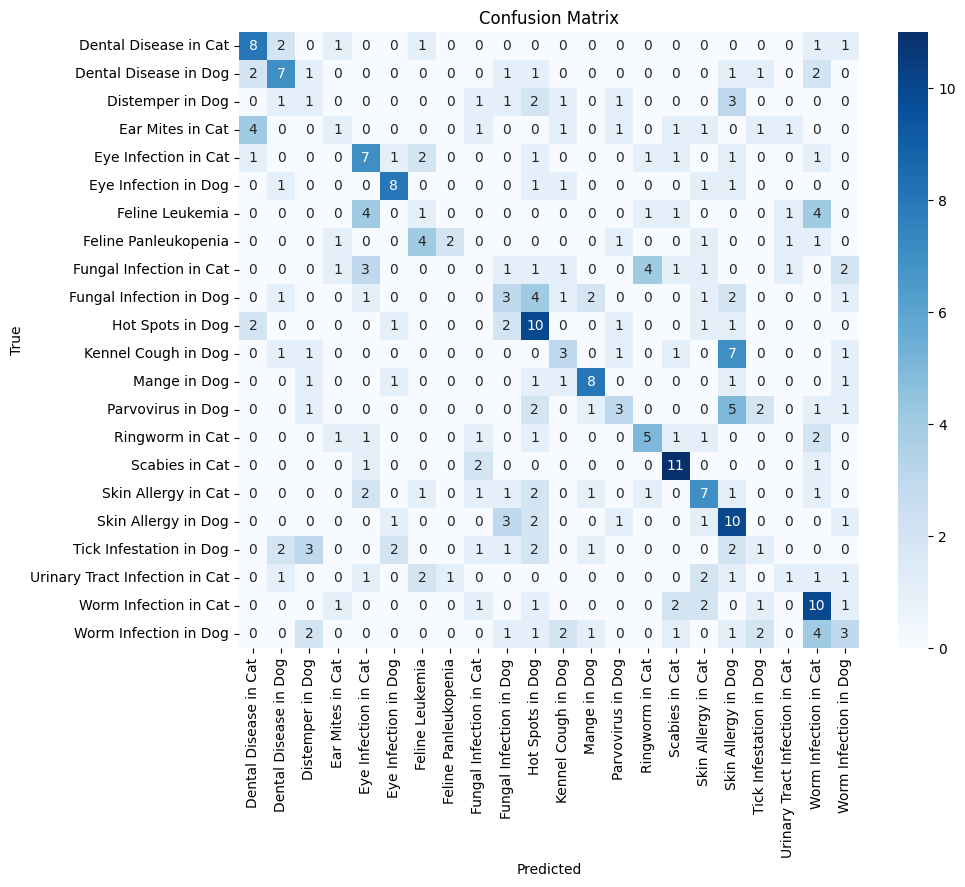

                                precision    recall  f1-score   support

         Dental Disease in Cat       0.47      0.57      0.52        14
         Dental Disease in Dog       0.44      0.44      0.44        16
              Distemper in Dog       0.10      0.09      0.10        11
              Ear Mites in Cat       0.17      0.08      0.11        12
          Eye Infection in Cat       0.35      0.44      0.39        16
          Eye Infection in Dog       0.57      0.62      0.59        13
               Feline Leukemia       0.09      0.08      0.09        12
          Feline Panleukopenia       0.67      0.18      0.29        11
       Fungal Infection in Cat       0.00      0.00      0.00        16
       Fungal Infection in Dog       0.21      0.19      0.20        16
              Hot Spots in Dog       0.31      0.56      0.40        18
           Kennel Cough in Dog       0.27      0.20      0.23        15
                  Mange in Dog       0.57      0.57      0.57  

In [5]:

val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


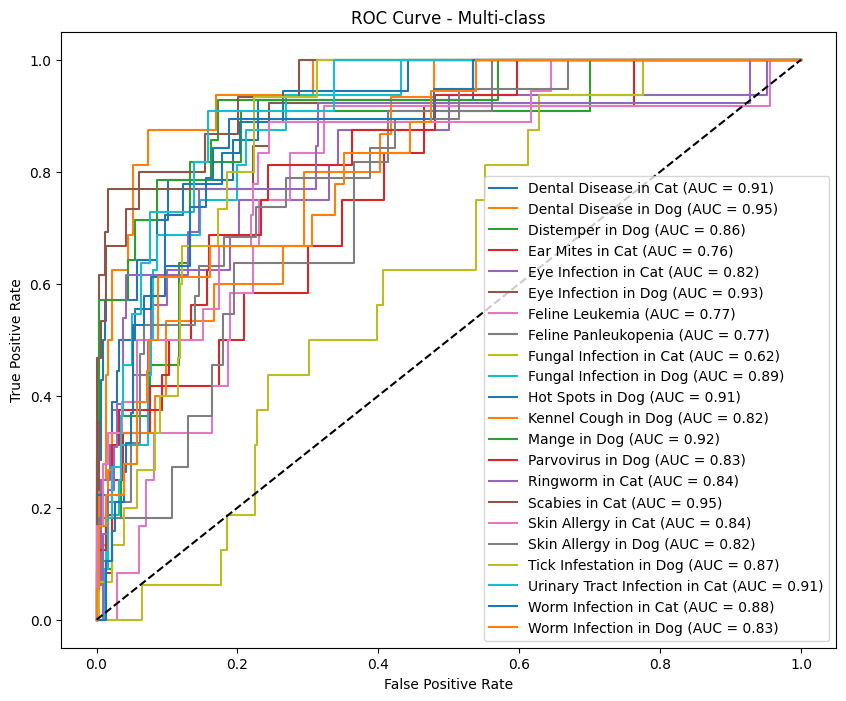

In [6]:

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class")
plt.legend()
plt.show()


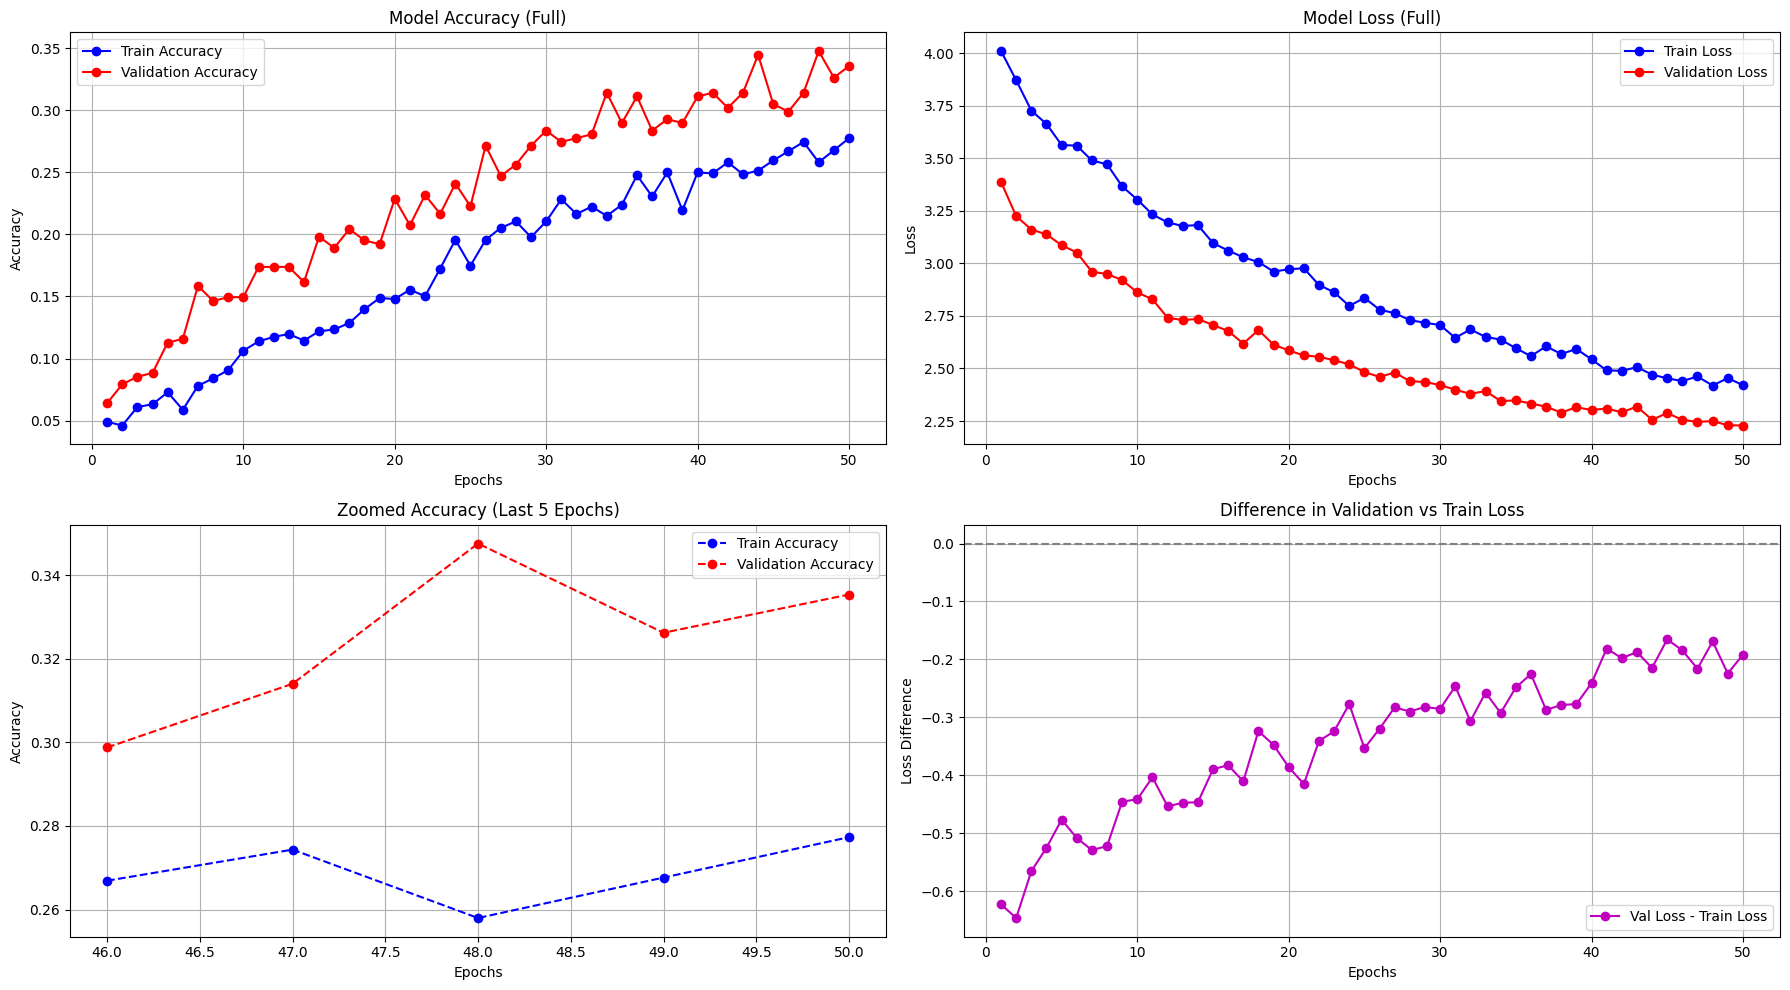

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(18, 10))

# 1. Full Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Model Accuracy (Full)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Full Loss Plot
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Train Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Model Loss (Full)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Zoomed-in Accuracy (Last 5 Epochs)
plt.subplot(2, 2, 3)
plt.plot(epochs_range[-5:], acc[-5:], 'bo--', label='Train Accuracy')
plt.plot(epochs_range[-5:], val_acc[-5:], 'ro--', label='Validation Accuracy')
plt.title('Zoomed Accuracy (Last 5 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 4. Train vs. Validation Loss Difference
plt.subplot(2, 2, 4)
loss_diff = np.array(val_loss) - np.array(loss)
plt.plot(epochs_range, loss_diff, 'mo-', label='Val Loss - Train Loss')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Validation vs Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
